# Peptides encoding

In [1]:
import peptides
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# libs for ml
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

Fetch all cdr3 sequences from VDJdb ver(vdjdb-2024-11-27-fixed) with `cut -f 2 vdjdb-2024-11-27-fixed/vdjdb.slim.txt | grep -v "cdr3" >cdr3_from_VDJdb.txt`

## Preparing data

Set length of sequence: 

In [2]:
len_seq = 15

In [3]:
with open("cdr3_from_VDJdb.txt") as file:
    count = 0
    pep_dir = []
    count_dir = 0
    for pep in file:
        pep = pep[:-1]
        count += 1
        if len(pep) == len_seq:
            count_dir +=1
            pep_dir.append(pep)
    print(f'From {count} only {count_dir} with the lengh of {len_seq}')

From 87032 only 18408 with the lengh of 15


In [4]:
 AA_LIST = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

In [5]:
pep_oh_encoded = np.zeros((count_dir, len(AA_LIST), len_seq), dtype = np.float32)
pep_af_encoded = np.zeros((count_dir, 5, len_seq), dtype = np.float32)
for k, pep in enumerate(pep_dir):
    for i in range(len(pep)):
        for j in range(len(AA_LIST)):
            if AA_LIST[j] == pep[i]:
                pep_oh_encoded[k][j][i] = 1
    for i in range(len(pep)):
        pep1 = peptides.Peptide(pep[i])
        for j, kf in enumerate(pep1.atchley_factors()):
            pep_af_encoded[k][j][i] = kf

In [6]:
print("First peptide (one-hot encoded):\n", pep_oh_encoded[3682])
print("First peptide (Atchley factors encoded):\n", np.round(pep_af_encoded[0], 2))
oh_matr_size = pep_oh_encoded[0].size
af_matr_size = pep_af_encoded[0].size

First peptide (one-hot encoded):
 [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
First

### Set Variables

In [7]:
latent_dims = 50 # надо посмотреть, что будет с длинной пептида и больше и меньше
num_epochs = 50 
batch_size = int(count_dir/8) # Тут надо быть аккуратней, чтобы делилось на цело
capacity = 64
learning_rate = 1e-3 
use_gpu = True

### Split datasets

In [8]:
#One-hot encoded
np.random.shuffle(pep_oh_encoded)
pep_oh_encoded_train = pep_oh_encoded[:int(round(count_dir*0.8, 0))]
pep_oh_encoded_test = pep_oh_encoded[int(round(count_dir*0.8, 0)):]

#Atchley factors encoded
np.random.shuffle(pep_af_encoded)
pep_af_encoded_train = pep_af_encoded[:int(round(count_dir*0.8, 0))]
pep_af_encoded_test = pep_af_encoded[int(round(count_dir*0.8, 0)):]

### Loading datasets

In [9]:
#One-hot encoded
oh_dataset = torch.utils.data.TensorDataset(torch.tensor(pep_oh_encoded), torch.tensor(np.ones(count_dir)))
oh_encoded_dl = torch.utils.data.DataLoader(oh_dataset, batch_size=batch_size, shuffle=True)

oh_dataset_train = torch.utils.data.TensorDataset(torch.tensor(pep_oh_encoded_train), torch.tensor(np.ones(int(round(count_dir*0.8, 0)))))
oh_encoded_dl_train = torch.utils.data.DataLoader(oh_dataset_train, batch_size=batch_size, shuffle=True)

oh_dataset_test = torch.utils.data.TensorDataset(torch.tensor(pep_oh_encoded_test), torch.tensor(np.ones(count_dir - int(round(count_dir*0.8, 0)))))
oh_encoded_dl_test = torch.utils.data.DataLoader(oh_dataset_test, batch_size=batch_size, shuffle=True)

#Atchley factors encoded
af_dataset = torch.utils.data.TensorDataset(torch.tensor(pep_af_encoded), torch.tensor(np.ones(count_dir)))
af_encoded_dl = torch.utils.data.DataLoader(af_dataset, batch_size=batch_size, shuffle=True)

af_dataset_train = torch.utils.data.TensorDataset(torch.tensor(pep_af_encoded_train), torch.tensor(np.ones(int(round(count_dir*0.8, 0)))))
af_encoded_dl_train = torch.utils.data.DataLoader(af_dataset_train, batch_size=batch_size, shuffle=True)

af_dataset_test = torch.utils.data.TensorDataset(torch.tensor(pep_af_encoded_test), torch.tensor(np.ones(count_dir - int(round(count_dir*0.8, 0)))))
af_encoded_dl_test = torch.utils.data.DataLoader(af_dataset_test, batch_size=batch_size, shuffle=True)

## Autoencoder_1SM definition (1 layer, Sigmoid, MSE loss) One-hot

In [10]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc = nn.Linear(in_features=20*len_seq, out_features=latent_dims)
            
    def forward(self, x):
        x = self.fc(x)
        #x = nn.ReLU(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(in_features=latent_dims, out_features=20*len_seq)
            
    def forward(self, x):
        x = self.fc(x)
        x = F.sigmoid(x)
        return x
    
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent)
        return x_recon
    
autoencoder_1sm_oh = Autoencoder() #One-hot encoding

if use_gpu and torch.cuda.is_available():
    device = torch.device("cuda:0")
elif use_gpu and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

autoencoder_1sm_oh = autoencoder_1sm_oh.to(device)

num_params = sum(p.numel() for p in autoencoder_1sm_oh.parameters() if p.requires_grad)
print('Number of parameters for One-hot encoding: %d' % num_params)

loss_function = nn.MSELoss()

Number of parameters for One-hot encoding: 30350


### Train autoencoder (One-hot)

In [11]:
optimizer = torch.optim.Adam(autoencoder_1sm_oh.parameters(), lr = learning_rate, weight_decay = 1e-5)
# set to training mode
autoencoder_1sm_oh.train()

train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    
    for pep_batch, _ in oh_encoded_dl_train:
        
        pep_batch = pep_batch.to(device)

        pep_batch = pep_batch.reshape(-1, oh_matr_size)
        
        # autoencoder reconstruction
        pep_batch_recon = autoencoder_1sm_oh(pep_batch)
        
        # reconstruction error
        loss = loss_function(pep_batch_recon, pep_batch)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

Training ...
Epoch [1 / 50] average reconstruction error: 0.245348
Epoch [2 / 50] average reconstruction error: 0.227798
Epoch [3 / 50] average reconstruction error: 0.196605
Epoch [4 / 50] average reconstruction error: 0.153154
Epoch [5 / 50] average reconstruction error: 0.106984
Epoch [6 / 50] average reconstruction error: 0.070795
Epoch [7 / 50] average reconstruction error: 0.049856
Epoch [8 / 50] average reconstruction error: 0.040299
Epoch [9 / 50] average reconstruction error: 0.036409
Epoch [10 / 50] average reconstruction error: 0.034700
Epoch [11 / 50] average reconstruction error: 0.033868
Epoch [12 / 50] average reconstruction error: 0.033377
Epoch [13 / 50] average reconstruction error: 0.033059
Epoch [14 / 50] average reconstruction error: 0.032801
Epoch [15 / 50] average reconstruction error: 0.032582
Epoch [16 / 50] average reconstruction error: 0.032411
Epoch [17 / 50] average reconstruction error: 0.032209
Epoch [18 / 50] average reconstruction error: 0.032051
Epoch 

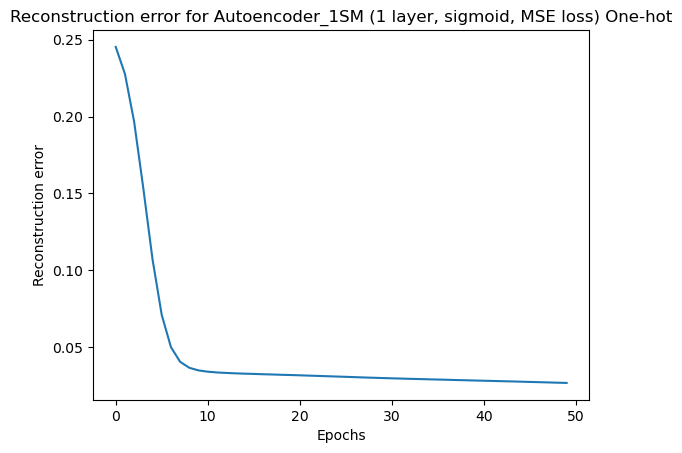

In [12]:
fig = plt.figure()
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Reconstruction error')
plt.title("Reconstruction error for Autoencoder_1SM (1 layer, sigmoid, MSE loss) One-hot")
plt.show()

### Evaluation One-hot

In [13]:
# set to evaluation mode
autoencoder_1sm_oh.eval()
counter = 0

test_loss_avg, num_batches = 0, 0
for pep_batch, _ in oh_encoded_dl_test:
    
    with torch.no_grad():

        pep_batch = pep_batch.to(device)

        pep_batch = pep_batch.reshape(-1, oh_matr_size)

        # autoencoder reconstruction
        pep_batch_recon = autoencoder_1sm_oh(pep_batch)

        # reconstruction error
        loss = loss_function(pep_batch_recon, pep_batch)

        if counter == 0:
            print("Example of reconstruction:")
            print("Before autoencoder:\n", pep_batch[0].reshape(len(AA_LIST), len_seq))
            print("Reconstruction error:", loss.item())
            print("After autoencoder:\n", torch.round(pep_batch_recon[0].reshape(len(AA_LIST), len_seq)))
            counter +=1

        test_loss_avg += loss.item()
        num_batches += 1
        
    
test_loss_avg /= num_batches
print('average reconstruction error: %f' % (test_loss_avg))

Example of reconstruction:
Before autoencoder:
 tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0

## Autoencoder_1SM definition (1 layer, Sigmoid, MSE loss) Atchley factors

In [14]:
class Encoder_af(nn.Module):
    def __init__(self):
        super(Encoder_af, self).__init__()
        self.fc = nn.Linear(in_features=5*len_seq, out_features=latent_dims)
            
    def forward(self, x):
        x = self.fc(x)
        #x = nn.ReLU(x)
        return x

class Decoder_af(nn.Module):
    def __init__(self):
        super(Decoder_af, self).__init__()
        self.fc = nn.Linear(in_features=latent_dims, out_features=5*len_seq)
            
    def forward(self, x):
        x = self.fc(x)
        #x = F.sigmoid(x) very bad results with sigmoid
        return x
    
class Autoencoder_af(nn.Module):
    def __init__(self):
        super(Autoencoder_af, self).__init__()
        self.encoder = Encoder_af()
        self.decoder = Decoder_af()
    
    def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent)
        return x_recon
    
autoencoder_1sm_af = Autoencoder_af() #Atchley factors encoded

if use_gpu and torch.cuda.is_available():
    device = torch.device("cuda:0")
elif use_gpu and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

autoencoder_1sm_af = autoencoder_1sm_af.to(device)

num_params = sum(p.numel() for p in autoencoder_1sm_af.parameters() if p.requires_grad)
print('Number of parameters for Atchley factors encoding: %d' % num_params)

loss_function = nn.MSELoss()

Number of parameters for Atchley factors encoding: 7625


### Train autoencoder (Atchley factors)

In [15]:
optimizer = torch.optim.Adam(autoencoder_1sm_af.parameters(), lr = learning_rate, weight_decay = 1e-5)
# set to training mode
autoencoder_1sm_af.train()

train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    
    for pep_batch, _ in af_encoded_dl_train:
        
        pep_batch = pep_batch.to(device)

        pep_batch = pep_batch.reshape(-1, af_matr_size)
        
        # autoencoder reconstruction
        pep_batch_recon = autoencoder_1sm_af(pep_batch)
        
        # reconstruction error
        loss = loss_function(pep_batch_recon, pep_batch)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

Training ...
Epoch [1 / 50] average reconstruction error: 2.267631
Epoch [2 / 50] average reconstruction error: 1.865444
Epoch [3 / 50] average reconstruction error: 1.532457
Epoch [4 / 50] average reconstruction error: 1.283672
Epoch [5 / 50] average reconstruction error: 1.118454
Epoch [6 / 50] average reconstruction error: 0.991441
Epoch [7 / 50] average reconstruction error: 0.881011
Epoch [8 / 50] average reconstruction error: 0.777920
Epoch [9 / 50] average reconstruction error: 0.683560
Epoch [10 / 50] average reconstruction error: 0.599879
Epoch [11 / 50] average reconstruction error: 0.527671
Epoch [12 / 50] average reconstruction error: 0.464357
Epoch [13 / 50] average reconstruction error: 0.412079
Epoch [14 / 50] average reconstruction error: 0.368407
Epoch [15 / 50] average reconstruction error: 0.332142
Epoch [16 / 50] average reconstruction error: 0.302388
Epoch [17 / 50] average reconstruction error: 0.277490
Epoch [18 / 50] average reconstruction error: 0.256331
Epoch 

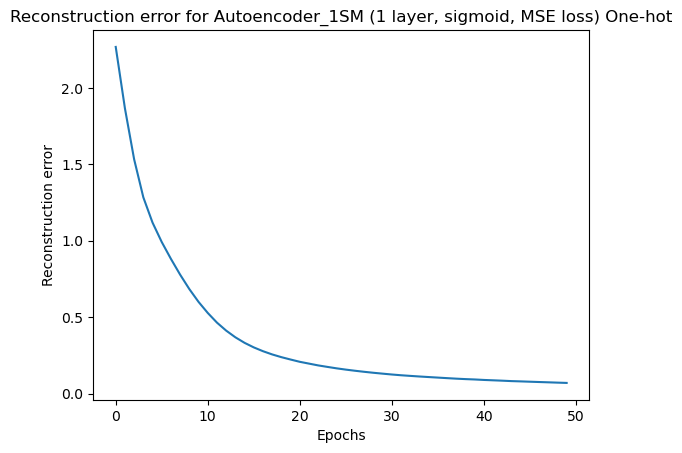

In [16]:
fig = plt.figure()
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Reconstruction error')
plt.title("Reconstruction error for Autoencoder_1SM (1 layer, sigmoid, MSE loss) One-hot")
plt.show()

In [17]:
# set to evaluation mode
autoencoder_1sm_af.eval()
counter = 0

test_loss_avg, num_batches = 0, 0
for pep_batch, _ in af_encoded_dl_test:
    
    with torch.no_grad():

        pep_batch = pep_batch.to(device)

        pep_batch = pep_batch.reshape(-1, af_matr_size)

        # autoencoder reconstruction
        pep_batch_recon = autoencoder_1sm_af(pep_batch)

        # reconstruction error
        loss = loss_function(pep_batch_recon, pep_batch)

        if counter == 0:
            print("Example of reconstruction:")
            print("Before autoencoder:\n", pep_batch[0].reshape(5, len_seq))
            print("Reconstruction error:", loss.item())
            print("After autoencoder:\n", pep_batch_recon[0].reshape(5, len_seq))
            counter +=1

        test_loss_avg += loss.item()
        num_batches += 1
        
    
test_loss_avg /= num_batches
print('\n\naverage reconstruction error: %f' % (test_loss_avg))

Example of reconstruction:
Before autoencoder:
 tensor([[-1.3427, -0.5915, -0.2279, -0.2279, -1.3366,  0.2600,  1.5375, -0.3839,
          0.9306, -0.5915,  0.9454,  1.3573,  0.9306, -1.0061, -1.0061],
        [ 0.4654, -1.3021,  1.3987,  1.3987, -0.2785,  0.8299, -0.0547,  1.6520,
         -0.1793, -1.3021,  0.8285, -1.4528, -0.1793, -0.5905, -0.5905],
        [-0.8620, -0.7331, -4.7596, -4.7596, -0.5440,  3.0974,  1.5021,  1.3301,
         -3.0049, -0.7331,  1.2991,  1.4767, -3.0049,  1.8910,  1.8910],
        [-1.0201,  1.5704,  0.6702,  0.6702,  1.2420, -0.8380,  0.4403,  1.0450,
         -0.5026,  1.5704, -0.1688,  0.1129, -0.5026, -0.3966, -0.3966],
        [-0.2552, -0.1455, -2.6475, -2.6475, -1.2623,  1.5115,  2.8974,  2.0639,
         -1.8530, -0.1455,  0.9334, -0.8372, -1.8530,  0.4119,  0.4119]],
       device='mps:0')
Reconstruction error: 0.06859856098890305
After autoencoder:
 tensor([[-1.2632, -0.5298,  0.0674, -0.0653, -1.3859,  0.3295,  1.2940, -0.3288,
          1.005

## Autoencoder_1SB definition (1 layer, Sigmoid, BCE loss)

In [18]:
autoencoder_1sb = Autoencoder()

if use_gpu and torch.cuda.is_available():
    device = torch.device("cuda:0")
elif use_gpu and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

autoencoder_1sb = autoencoder_1sb.to(device)

num_params = sum(p.numel() for p in autoencoder_1sb.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

loss_function = nn.BCELoss()

optimizer = torch.optim.Adam(autoencoder_1sb.parameters(), lr = learning_rate, weight_decay = 1e-5)

Number of parameters: 30350


### Train

In [19]:
autoencoder_1sb.train()

train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    
    for pep_batch, _ in oh_encoded_dl_train:
        
        pep_batch = pep_batch.to(device)

        pep_batch = pep_batch.reshape(-1, oh_matr_size)
        
        # autoencoder reconstruction
        pep_batch_recon = autoencoder_1sb(pep_batch)
        
        # reconstruction error
        loss = loss_function(pep_batch_recon, pep_batch)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

Training ...
Epoch [1 / 50] average reconstruction error: 0.682973
Epoch [2 / 50] average reconstruction error: 0.644483
Epoch [3 / 50] average reconstruction error: 0.576643
Epoch [4 / 50] average reconstruction error: 0.481542
Epoch [5 / 50] average reconstruction error: 0.374100
Epoch [6 / 50] average reconstruction error: 0.277395
Epoch [7 / 50] average reconstruction error: 0.208518
Epoch [8 / 50] average reconstruction error: 0.168524
Epoch [9 / 50] average reconstruction error: 0.148097
Epoch [10 / 50] average reconstruction error: 0.138016
Epoch [11 / 50] average reconstruction error: 0.132431
Epoch [12 / 50] average reconstruction error: 0.128992
Epoch [13 / 50] average reconstruction error: 0.126835
Epoch [14 / 50] average reconstruction error: 0.125267
Epoch [15 / 50] average reconstruction error: 0.124231
Epoch [16 / 50] average reconstruction error: 0.123235
Epoch [17 / 50] average reconstruction error: 0.122349
Epoch [18 / 50] average reconstruction error: 0.121595
Epoch 

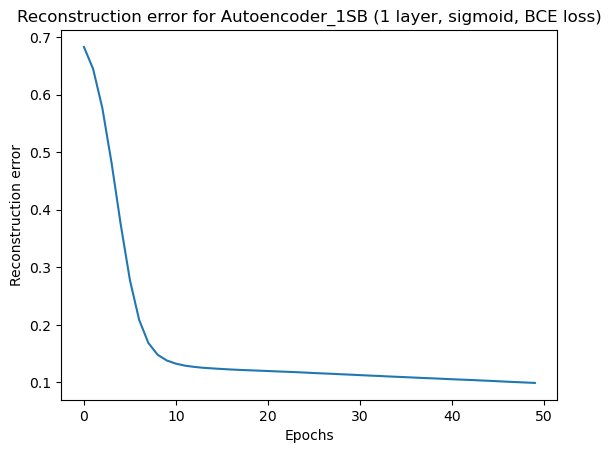

In [20]:
fig = plt.figure()
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Reconstruction error')
plt.title("Reconstruction error for Autoencoder_1SB (1 layer, sigmoid, BCE loss)")
plt.show()

In [21]:
# set to evaluation mode
autoencoder_1sb.eval()
counter = 0

test_loss_avg, num_batches = 0, 0
for pep_batch, _ in oh_encoded_dl_test:
    
    with torch.no_grad():

        pep_batch = pep_batch.to(device)

        pep_batch = pep_batch.reshape(-1, oh_matr_size)

        # autoencoder reconstruction
        pep_batch_recon = autoencoder_1sb(pep_batch)

        # reconstruction error
        loss = loss_function(pep_batch_recon, pep_batch)

        if counter == 0:
            print("Example of reconstruction:")
            print("Before autoencoder:\n", pep_batch[0].reshape(len(AA_LIST), len_seq))
            print("Reconstruction error:", loss.item())
            print("After autoencoder:\n", torch.round(pep_batch_recon[0].reshape(len(AA_LIST), len_seq)))
            counter +=1

        test_loss_avg += loss.item()
        num_batches += 1
        
    
test_loss_avg /= num_batches
print('average reconstruction error: %f' % (test_loss_avg))

Example of reconstruction:
Before autoencoder:
 tensor([[0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0